**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [182]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [183]:
import os
import tarfile
from six.moves import urllib

AIR_BNB_PATH = os.path.join("datasets", "new-york-city-airbnb-open-data")



In [184]:
import pandas as pd

def load_air_bnb_data(air_bnb_path=AIR_BNB_PATH):
    csv_path = os.path.join(AIR_BNB_PATH, "AB_NYC_2019.csv")
    return pd.read_csv(csv_path)

In [185]:
bnb = load_air_bnb_data()
bnb.head()
bnb = bnb.drop(["last_review"],axis=1)
bnb["reviews_per_month"] = bnb["reviews_per_month"].fillna(0)
bnb = bnb.dropna()

In [186]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48858 entries, 0 to 48894
Data columns (total 15 columns):
id                                48858 non-null int64
name                              48858 non-null object
host_id                           48858 non-null int64
host_name                         48858 non-null object
neighbourhood_group               48858 non-null object
neighbourhood                     48858 non-null object
latitude                          48858 non-null float64
longitude                         48858 non-null float64
room_type                         48858 non-null object
price                             48858 non-null int64
minimum_nights                    48858 non-null int64
number_of_reviews                 48858 non-null int64
reviews_per_month                 48858 non-null float64
calculated_host_listings_count    48858 non-null int64
availability_365                  48858 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 6

In [187]:
bnb["room_type"].value_counts()

Entire home/apt    25393
Private room       22306
Shared room         1159
Name: room_type, dtype: int64

In [188]:
bnb.describe()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.885800e+04,4.885800e+04,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000
mean,1.902335e+07,6.763169e+07,40.728941,-73.952170,152.740309,7.012444,23.273098,1.091124,7.148369,112.801425
std,1.098289e+07,7.862389e+07,0.054528,0.046159,240.232386,20.019757,44.549898,1.597270,32.964600,131.610962
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.475980e+06,7.818669e+06,40.690090,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.969114e+07,3.079133e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915765e+07,1.074344e+08,40.763107,-73.936280,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [189]:
bnb = bnb.dropna(subset=["price"]) 
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Saving figure attribute_histogram_plots


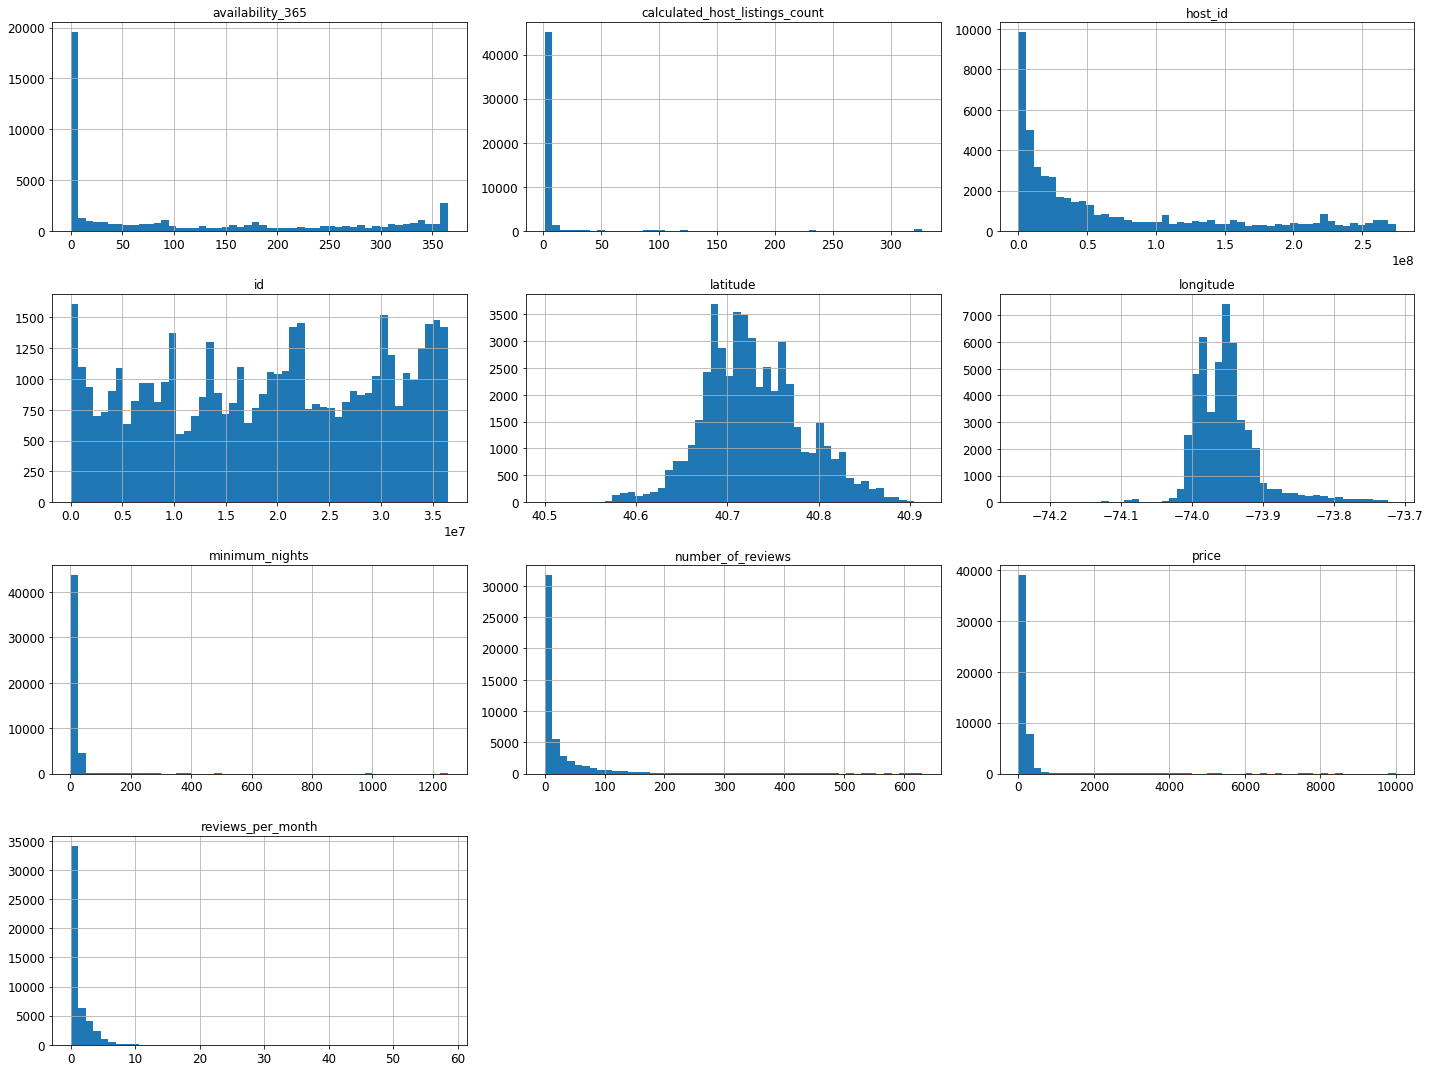

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
bnb.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [191]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [192]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

In [193]:
test_set.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
5880,4285876,LES/Chinatown One Bedroom apt (all to yourself),22248783,Xiao,Manhattan,Lower East Side,40.71281,-73.99174,Entire home/apt,140,1,16,0.28,1,0
35926,28539464,"#2BED Luxury Midtown Full Kitchen, Comp Breakfast",214347105,Roman,Manhattan,Midtown,40.75306,-73.96662,Entire home/apt,399,3,13,1.48,8,229
16413,13182297,Sculptor's Light-filled Loft (Bushwick),18742,Serra Victoria,Brooklyn,Bushwick,40.70430,-73.92491,Entire home/apt,117,7,0,0.00,1,0
23347,18898808,BK's Finest Jack&Jill ShareRoom Close to Train...,50600973,Joyell,Brooklyn,Bushwick,40.69674,-73.92972,Shared room,25,1,105,4.22,7,82
2531,1305346,Studio in the Heart of Soho,7096964,Chris,Manhattan,SoHo,40.72098,-73.99869,Entire home/apt,145,30,12,0.17,1,342


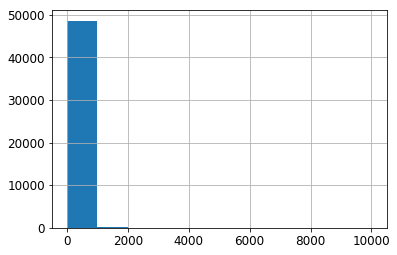

In [194]:

bnb["price"].hist()

**Warning**: in the book, I did not use `pd.cut()`, instead I used the code below. The `pd.cut()` solution gives the same result (except the labels are integers instead of floats), but it is simpler to understand:

```python
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
```

In [241]:
bnb["price_cat"] = pd.cut(bnb["price"],
                               bins=[0.0,50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0 ,bnb["price"].max()],
                               labels=[25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0 , 425.0, 475.0])

In [243]:
bnb = bnb.dropna(subset=["price_cat"])
len(bnb)

48847

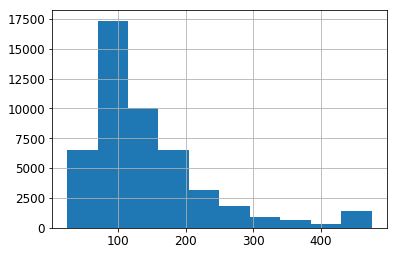

In [244]:
bnb["price_cat"].hist()

In [228]:
bnb["price_cat"][0].dtype

dtype('float64')

In [229]:
bnb.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,125.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,225.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,125.0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,75.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,75.0


In [230]:
from sklearn.model_selection import StratifiedShuffleSplit
#strat_train_set, strat_test_set = train_test_split(bnb, test_size=0.2, random_state = 42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#split.split(bnb, bnb["price_cat"])
for train_index, test_index in split.split(bnb, bnb["price_cat"]):
    strat_train_set = bnb.loc[train_index]
    strat_test_set = bnb.loc[test_index]

/Users/beneagar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/beneagar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [231]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

75.0     0.359980
125.0    0.199181
25.0     0.142579
175.0    0.124258
225.0    0.065097
275.0    0.036029
475.0    0.030194
325.0    0.019652
375.0    0.014637
425.0    0.007165
Name: price_cat, dtype: float64

In [232]:
bnb["price_cat"].value_counts() / len(bnb)

75.0     0.355314
125.0    0.205151
175.0    0.134092
25.0     0.133928
225.0    0.064958
275.0    0.037873
475.0    0.029480
325.0    0.018425
375.0    0.014167
425.0    0.006612
Name: price_cat, dtype: float64

In [238]:
def income_cat_proportions(data):
    return data["price_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(bnb),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [239]:
def price_cat_proportions(data):
    return data["pice_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(bnb, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(bnb),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [204]:
compare_props

NameError: name 'compare_props' is not defined

In [100]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

KeyError: "['income_cat'] not found in axis"

# Discover and visualize the data to gain insights

In [245]:
bnb = strat_train_set.copy()

Saving figure bad_visualization_plot


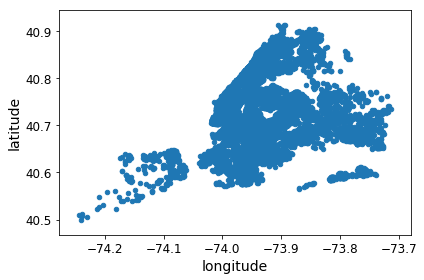

In [246]:
bnb.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


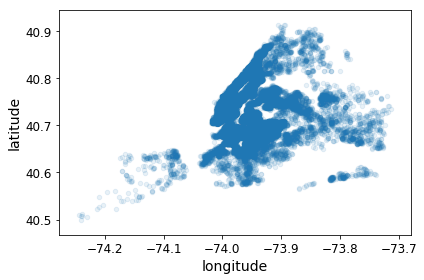

In [247]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

In [104]:
bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.908600e+04,3.908600e+04,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000
mean,1.898940e+07,6.752088e+07,40.728911,-73.952290,153.185847,6.997876,23.398224,1.094515,6.993527,112.653866
std,1.096561e+07,7.839918e+07,0.054598,0.046237,243.970979,19.683643,44.639915,1.606215,32.069503,131.685874
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.464662e+06,7.784226e+06,40.690112,-73.983190,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.960327e+07,3.106947e+07,40.723110,-73.955730,107.000000,2.000000,5.000000,0.380000,1.000000,45.000000
75%,2.911758e+07,1.074344e+08,40.763110,-73.936180,175.000000,5.000000,24.000000,1.590000,2.000000,226.750000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,999.000000,629.000000,58.500000,327.000000,365.000000


Saving figure housing_prices_scatterplot


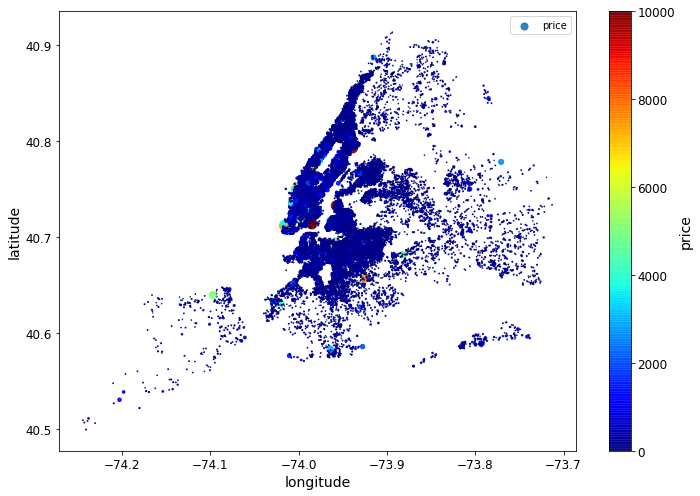

In [105]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
    s=bnb["price"]/100, label="price", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [100]:
NY_img.extent=[ -74.0, -73.0, 40.0, 41.0],

5135598

Saving figure california_housing_prices_plot


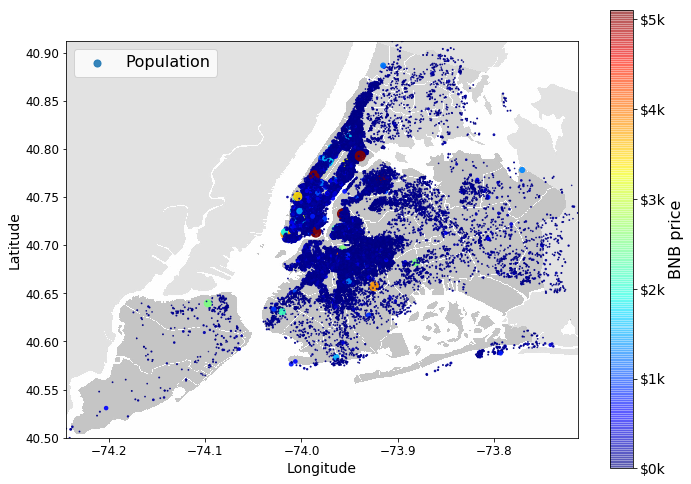

In [251]:
import matplotlib.image as mpimg
NY_img=mpimg.imread(PROJECT_ROOT_DIR + r'/datasets/new-york-city-airbnb-open-data/New_York_City_.png',0)
ax = bnb.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=bnb['price']/100, label="Population",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.9,
                      )

plt.imshow(NY_img,  alpha=0.4,extent=[bnb["longitude"].min(), bnb["longitude"].max(), bnb["latitude"].min(), bnb["latitude"].max()],
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = bnb["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('BNB price', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [ ]:
PROJECT_ROOT_DIR

In [107]:
corr_matrix = bnb.corr()

In [108]:
corr_matrix["price"].sort_values(ascending=False)

price                             1.000000
availability_365                  0.081454
calculated_host_listings_count    0.056642
minimum_nights                    0.034893
latitude                          0.033419
host_id                           0.013656
id                                0.008576
number_of_reviews                -0.048713
reviews_per_month                -0.051908
longitude                        -0.149850
Name: price, dtype: float64

In [109]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["price_cat", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

NameError: name 'housing' is not defined

Saving figure income_vs_house_value_scatterplot


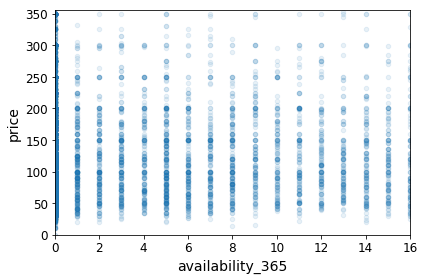

In [112]:
bnb.plot(kind="scatter", y="price", x="availability_365",
             alpha=0.1)
plt.axis([0, 16, 0, 356])
save_fig("income_vs_house_value_scatterplot")

In [113]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
24040,19382819,LUXURY STUDIO ON UPPER EAST SIDE BY CENTRAL PARK,9293730,Inna,Manhattan,Upper East Side,40.76833,-73.95581,Entire home/apt,135,30,9,0.38,16,340,125
34061,26989176,"Modern, Cozy Apt Share for Young Professionals",2822805,Ollie,Brooklyn,Bedford-Stuyvesant,40.68585,-73.94919,Private room,60,30,3,0.45,8,221,75
551,204833,"Great, spacious apt in Williamsburg",903686,Melanie,Brooklyn,Williamsburg,40.70930,-73.94970,Private room,100,6,8,0.09,1,249,75
18877,14983453,127 St & Convent Av NYC ABCD RM 3,57049951,Eliahu,Manhattan,Harlem,40.81205,-73.95273,Private room,69,2,100,3.09,9,345,75
16721,13373898,Sunny Designer Gem for Families & Couples! #10304,8961407,Jamie,Manhattan,Harlem,40.80570,-73.94689,Entire home/apt,350,3,46,1.30,3,297,325


Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [114]:
corr_matrix = bnb.corr()
corr_matrix["price"].sort_values(ascending=False)

price                             1.000000
availability_365                  0.081454
calculated_host_listings_count    0.056642
minimum_nights                    0.034893
latitude                          0.033419
host_id                           0.013656
id                                0.008576
number_of_reviews                -0.048713
reviews_per_month                -0.051908
longitude                        -0.149850
Name: price, dtype: float64

In [116]:
bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.908600e+04,3.908600e+04,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000,39086.000000
mean,1.898940e+07,6.752088e+07,40.728911,-73.952290,153.185847,6.997876,23.398224,1.094515,6.993527,112.653866
std,1.096561e+07,7.839918e+07,0.054598,0.046237,243.970979,19.683643,44.639915,1.606215,32.069503,131.685874
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.464662e+06,7.784226e+06,40.690112,-73.983190,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.960327e+07,3.106947e+07,40.723110,-73.955730,107.000000,2.000000,5.000000,0.380000,1.000000,45.000000
75%,2.911758e+07,1.074344e+08,40.763110,-73.936180,175.000000,5.000000,24.000000,1.590000,2.000000,226.750000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,999.000000,629.000000,58.500000,327.000000,365.000000


# Prepare the data for Machine Learning algorithms

In [118]:
bnb = strat_train_set.drop("price", axis=1) # drop labels for training set
bnb_labels = strat_train_set["price"].copy()

In [136]:
sample_incomplete_rows = bnb[bnb.isnull().any(axis=1)].head()
sample_incomplete_rows

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
26866,21304320,Best Coliving space ever! Shared room.,101970559,Sergii,Brooklyn,Bushwick,40.69166,-73.90928,Shared room,30,5,0.26,6,139,NaN
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,30,2,0.11,6,333,NaN
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,3,0,0.00,1,0,NaN
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,1,95,4.35,6,222,NaN
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,1,93,4.28,6,176,NaN


In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [120]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [122]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_cat
24040,19382819,LUXURY STUDIO ON UPPER EAST SIDE BY CENTRAL PARK,9293730,Inna,Manhattan,Upper East Side,40.76833,-73.95581,Entire home/apt,30,9,0.38,16,340,125
34061,26989176,"Modern, Cozy Apt Share for Young Professionals",2822805,Ollie,Brooklyn,Bedford-Stuyvesant,40.68585,-73.94919,Private room,30,3,0.45,8,221,75
551,204833,"Great, spacious apt in Williamsburg",903686,Melanie,Brooklyn,Williamsburg,40.70930,-73.94970,Private room,6,8,0.09,1,249,75
18877,14983453,127 St & Convent Av NYC ABCD RM 3,57049951,Eliahu,Manhattan,Harlem,40.81205,-73.95273,Private room,2,100,3.09,9,345,75
16721,13373898,Sunny Designer Gem for Families & Couples! #10304,8961407,Jamie,Manhattan,Harlem,40.80570,-73.94689,Entire home/apt,3,46,1.30,3,297,325


In [128]:
#bnb_num = bnb.drop(['name',"host_name","neighbourhood_group","neighbourhood"], axis=1)
bnb_num = bnb.select_dtypes(include=[np.number])

Remove the text attribute because median can only be calculated on numerical attributes:

In [129]:
imputer.fit(bnb_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [130]:
imputer.statistics_

array([ 1.96032710e+07,  3.10694715e+07,  4.07231100e+01, -7.39557300e+01,
        2.00000000e+00,  5.00000000e+00,  3.80000000e-01,  1.00000000e+00,
        4.50000000e+01])

Check that this is the same as manually computing the median of each attribute:

In [131]:
bnb_num.median().values

array([ 1.96032710e+07,  3.10694715e+07,  4.07231100e+01, -7.39557300e+01,
        2.00000000e+00,  5.00000000e+00,  3.80000000e-01,  1.00000000e+00,
        4.50000000e+01])

Transform the training set:

In [132]:
X = imputer.transform(bnb_num)

In [133]:
bnb_tr = pd.DataFrame(X, columns=bnb_num.columns,
                          index=bnb.index)

In [137]:
bnb_tr.loc[sample_incomplete_rows.index.values]

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
26866,21304320.0,101970559.0,40.69166,-73.90928,30.0,5.0,0.26,6.0,139.0
26841,21291569.0,101970559.0,40.69211,-73.90670,30.0,2.0,0.11,6.0,333.0
26259,20933849.0,13709292.0,40.75091,-73.97597,3.0,0.0,0.00,1.0,0.0
25796,20639914.0,86327101.0,40.68258,-73.91284,1.0,95.0,4.35,6.0,222.0
25794,20639628.0,86327101.0,40.68173,-73.91342,1.0,93.0,4.28,6.0,176.0


In [138]:
imputer.strategy

'median'

In [141]:
bnb_tr = pd.DataFrame(X, columns=bnb_num.columns,
                          index=bnb_num.index)
bnb_tr.head()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
24040,19382819.0,9293730.0,40.76833,-73.95581,30.0,9.0,0.38,16.0,340.0
34061,26989176.0,2822805.0,40.68585,-73.94919,30.0,3.0,0.45,8.0,221.0
551,204833.0,903686.0,40.70930,-73.94970,6.0,8.0,0.09,1.0,249.0
18877,14983453.0,57049951.0,40.81205,-73.95273,2.0,100.0,3.09,9.0,345.0
16721,13373898.0,8961407.0,40.80570,-73.94689,3.0,46.0,1.30,3.0,297.0


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
#bnb_cat = bnb[['ocean_proximity']]
#housing_cat.head(10)

**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

In [142]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [143]:
ordinal_encoder = OrdinalEncoder()
bnb_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
bnb_cat_encoded[:10]

NameError: name 'housing_cat' is not defined

In [ ]:
ordinal_encoder.categories_

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [ ]:
housing_cat_1hot.toarray()

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

Let's create a custom transformer to add extra attributes:

In [144]:
bnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price_cat'],
      dtype='object')

In [145]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

NameError: name 'housing' is not defined

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features (again, we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

The result is the same as with the `ColumnTransformer`:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

# Select and train a model 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)